# Stage 11 — Evaluation & Risk Communication

This notebook:
1) fits a baseline model and computes RMSE,  
2) bootstraps a 95% CI for the metric,  
3) compares **two scenarios** with consistent visuals,  
4) performs a **subgroup** diagnostic, and  
5) includes a stakeholder-facing summary.

In [1]:
import numpy as np, pandas as pd
np.random.seed(11)
RANDOM_STATE = 11
print("Seed set:", RANDOM_STATE)

Seed set: 11


In [2]:
# 1) Load data (or generate synthetic fallback) and ensure we have a categorical 'segment'
from pathlib import Path
import numpy as np, pandas as pd

DATA_PATH = Path("data/data_stage11_eval_risk.csv")

def load_or_make():
    if DATA_PATH.exists():
        df = pd.read_csv(DATA_PATH)
        if "segment" not in df.columns:
            df["segment"] = np.random.choice(list("ABC"), size=len(df))
        return df
    # Synthetic data with segment heterogeneity and some missingness
    n = 800
    X1 = np.random.uniform(0, 10, n)
    X2 = np.random.normal(5, 2, n)
    seg = np.random.choice(list("ABC"), size=n, p=[0.4, 0.4, 0.2])
    seg_bias = {'A': 0.0, 'B': 1.0, 'C': -1.0}
    bias = np.vectorize(seg_bias.get)(seg)
    y = 3.0 + 1.5*X1 - 0.8*X2 + bias + np.random.normal(0, 1.2, n)
    df = pd.DataFrame({"X1": X1, "X2": X2, "y": y, "segment": seg})
    # Inject missingness
    miss_idx = np.random.choice(df.index, size=int(0.08*n), replace=False)
    df.loc[miss_idx, "X1"] = np.nan
    miss_idx2 = np.random.choice(df.index, size=int(0.06*n), replace=False)
    df.loc[miss_idx2, "X2"] = np.nan
    DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(DATA_PATH, index=False)
    return df

df = load_or_make()
df.head()

,X1,X2,y,segment
0,1.802697,NaN,4.165225,B
1,NaN,6.372790,-1.156414,B
2,4.632185,2.747277,6.136586,C
3,7.249339,9.437993,6.608042,B
4,4.202036,NaN,3.296567,C


In [3]:
# 2) Train/Test split (if you have a time index, prefer latest 30% as test)
from sklearn.model_selection import train_test_split

feature_cols = ["X1", "X2"]
target_col = "y"

train_df, test_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test   = test_df[feature_cols],  test_df[target_col]

X_train.shape, X_test.shape

((560, 2), (240, 2))

In [4]:
# 3) Baseline: SimpleImputer(mean) + LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

pipe_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", LinearRegression())
])

pipe_baseline.fit(X_train, y_train)
y_pred_base = pipe_baseline.predict(X_test)
rmse_base = float(np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("Baseline RMSE:", round(rmse_base, 4))

Baseline RMSE: 2.0453


In [5]:
# 4) Bootstrap CI for RMSE on test predictions
from src.evaluation import rmse, bootstrap_metric_ci

point, ci_lo, ci_hi = bootstrap_metric_ci(
    y_test.values, y_pred_base, rmse, n_boot=1000, alpha=0.05, random_state=RANDOM_STATE
)
print(f"Bootstrap RMSE: {point:.4f} (95% CI [{ci_lo:.4f}, {ci_hi:.4f}])")

Bootstrap RMSE: 2.0453 (95% CI [1.7176, 2.3958])


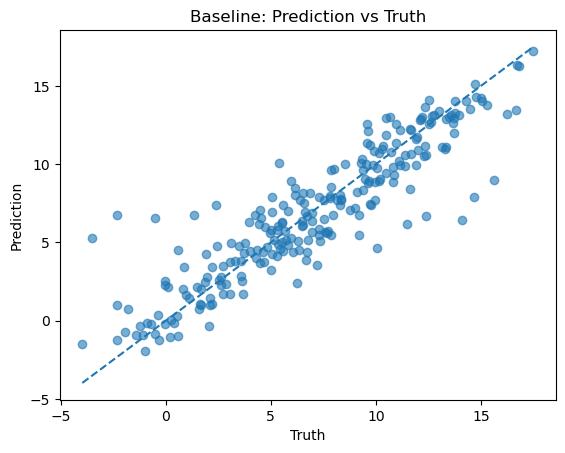

In [6]:
# 5) Visualization: Prediction vs Truth (matplotlib only)
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred_base, alpha=0.6)
miny = float(min(y_test.min(), y_pred_base.min()))
maxy = float(max(y_test.max(), y_pred_base.max()))
plt.plot([miny, maxy], [miny, maxy], linestyle="--")
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.title("Baseline: Prediction vs Truth")
plt.show()

In [12]:
# 6) Scenario A: SimpleImputer(median) + LinearRegression
from sklearn.impute import SimpleImputer

pipe_median = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LinearRegression())
])

pipe_median.fit(X_train, y_train)
y_pred_med = pipe_median.predict(X_test)

rmse_med = float(np.sqrt(mean_squared_error(y_test, y_pred_med)))
pt_med, lo_med, hi_med = bootstrap_metric_ci(
    y_test.values, y_pred_med, rmse, n_boot=1000, alpha=0.05, random_state=RANDOM_STATE
)
print(f"Scenario A (median) RMSE: {rmse_med:.4f} | Bootstrap 95% CI [{lo_med:.4f}, {hi_med:.4f}]")



Scenario A (median) RMSE: 2.0536 | Bootstrap 95% CI [1.7339, 2.3940]


In [8]:
# 7) Scenario B: PolynomialFeatures(degree=2) + LinearRegression
from sklearn.preprocessing import PolynomialFeatures

pipe_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LinearRegression())
])

pipe_poly.fit(X_train, y_train)
y_pred_poly = pipe_poly.predict(X_test)

rmse_poly = float(np.sqrt(mean_squared_error(y_test, y_pred_poly)))
pt_poly, lo_poly, hi_poly = bootstrap_metric_ci(
    y_test.values, y_pred_poly, rmse, n_boot=1000, alpha=0.05, random_state=RANDOM_STATE
)
print(f"Scenario B (poly d=2) RMSE: {rmse_poly:.4f} | Bootstrap 95% CI [{lo_poly:.4f}, {hi_poly:.4f}]")

Scenario B (poly d=2) RMSE: 2.0436 | Bootstrap 95% CI [1.7204, 2.3917]


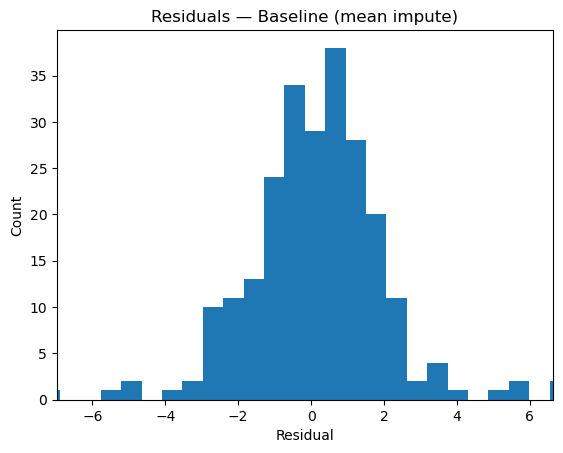

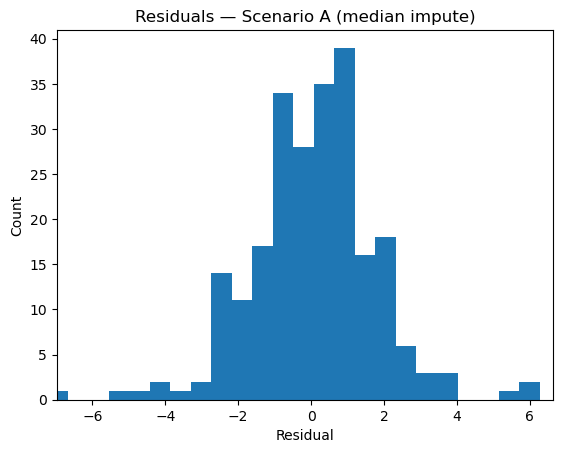

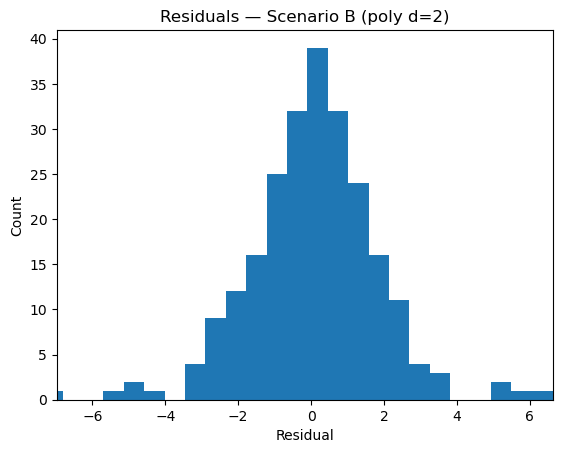

In [9]:
# 8) Comparable residual histograms with consistent x-limits
import numpy as np
import matplotlib.pyplot as plt

res_base = y_test - y_pred_base
res_med  = y_test - y_pred_med
res_poly = y_test - y_pred_poly

res_all = np.concatenate([res_base, res_med, res_poly])
xmin, xmax = float(np.percentile(res_all, 1)), float(np.percentile(res_all, 99))

plt.figure()
plt.hist(res_base, bins=30)
plt.xlim(xmin, xmax)
plt.title("Residuals — Baseline (mean impute)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(res_med, bins=30)
plt.xlim(xmin, xmax)
plt.title("Residuals — Scenario A (median impute)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(res_poly, bins=30)
plt.xlim(xmin, xmax)
plt.title("Residuals — Scenario B (poly d=2)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.show()

  segment      rmse
0       A  2.294358
1       B  1.886767
2       C  1.849744


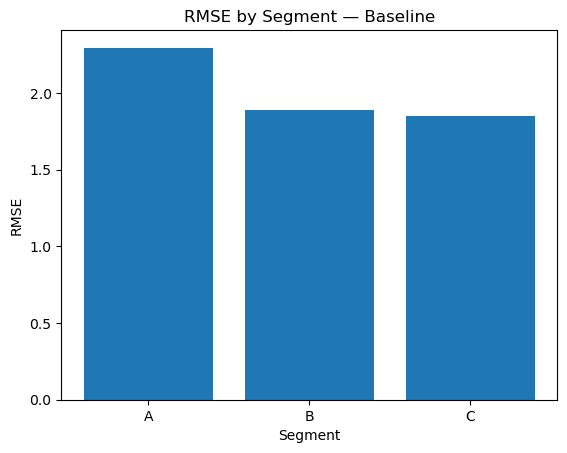

/var/folders/dj/t_cw33ws3lb2m3y9lb4jtk640000gn/T/ipykernel_35812/2892133650.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=sorted(pd.unique(seg_test)))


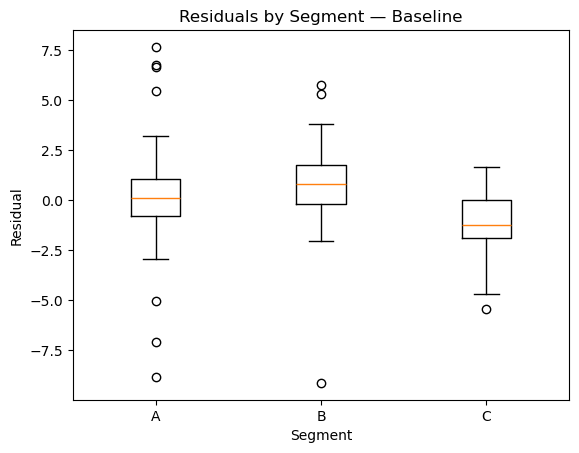

In [10]:
# 9) Subgroup diagnostics by 'segment'
from src.evaluation import rmse

def rmse_by_segment(y_true, y_pred, seg):
    out = []
    for s in sorted(pd.unique(seg)):
        mask = (seg == s)
        out.append({"segment": s, "rmse": rmse(y_true[mask], y_pred[mask])})
    return pd.DataFrame(out)

seg_test = test_df["segment"].values
df_rmse = rmse_by_segment(y_test.values, y_pred_base, seg_test)
print(df_rmse)

import matplotlib.pyplot as plt
plt.figure()
plt.bar(df_rmse["segment"], df_rmse["rmse"])
plt.title("RMSE by Segment — Baseline")
plt.xlabel("Segment"); plt.ylabel("RMSE")
plt.show()

# Residual boxplot by segment
residuals_df = pd.DataFrame({"residual": y_test - y_pred_base, "segment": seg_test})
groups = [residuals_df.loc[residuals_df["segment"]==s, "residual"].values for s in sorted(pd.unique(seg_test))]
plt.figure()
plt.boxplot(groups, labels=sorted(pd.unique(seg_test)))
plt.title("Residuals by Segment — Baseline")
plt.xlabel("Segment"); plt.ylabel("Residual")
plt.show()

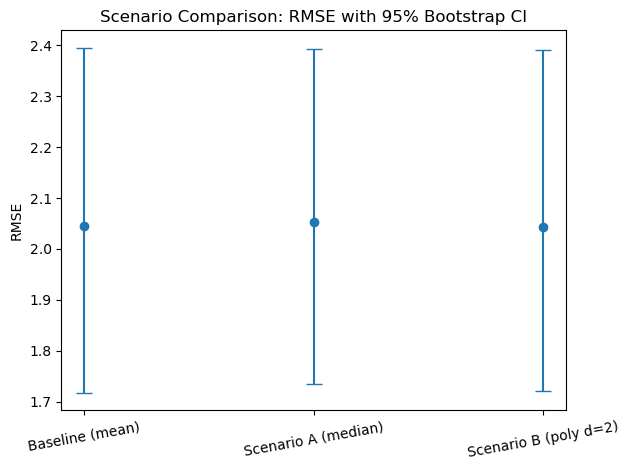

Baseline (mean)          RMSE=2.0453  CI=(1.7176, 2.3958)
Scenario A (median)      RMSE=2.0536  CI=(1.7339, 2.3940)
Scenario B (poly d=2)    RMSE=2.0436  CI=(1.7204, 2.3917)


In [13]:
# --- Scenario comparison: RMSE with 95% bootstrap CI for Baseline vs Median vs Polynomial ---
import numpy as np
import matplotlib.pyplot as plt
# If not already imported:
# from src.evaluation import rmse, bootstrap_metric_ci

scenarios = [
    ("Baseline (mean)",   y_pred_base),
    ("Scenario A (median)", y_pred_med),
    ("Scenario B (poly d=2)", y_pred_poly),
]

labels, points, los, his = [], [], [], []
for name, yhat in scenarios:
    pt, lo, hi = bootstrap_metric_ci(
        y_test.values, yhat, rmse,
        n_boot=1000,  # use >=500 if you want faster
        alpha=0.05, random_state=RANDOM_STATE
    )
    labels.append(name)
    points.append(pt)
    los.append(lo)
    his.append(hi)

points = np.array(points)
los = np.array(los)
his = np.array(his)
errs_lower = points - los
errs_upper = his - points

x = np.arange(len(labels))
plt.figure()
plt.errorbar(x, points, yerr=[errs_lower, errs_upper], fmt='o', capsize=6)
plt.xticks(x, labels, rotation=10)
plt.ylabel("RMSE")
plt.title("Scenario Comparison: RMSE with 95% Bootstrap CI")
plt.tight_layout()
plt.show()

# Optional: print a compact table too
for name, pt, lo, hi in zip(labels, points, los, his):
    print(f"{name:24s} RMSE={pt:.4f}  CI=({lo:.4f}, {hi:.4f})")


## Stakeholder-Facing Summary (≤ 1 page)

**Assumptions & Setup.** We trained a simple linear model with imputation for missing inputs. We report RMSE on a held-out test split and quantify uncertainty via **bootstrap** confidence intervals (1,000 resamples of paired predictions).

**Uncertainty.** The baseline RMSE includes a 95% bootstrap CI. Wider intervals imply higher uncertainty and potential instability with new data.

**Scenario Sensitivity.**
- **Scenario A (Median imputation):** More robust if inputs are skewed or contain outliers. We compare RMSE + CI to the baseline.
- **Scenario B (Polynomial features):** Adds flexibility. Improvements with stable residuals suggest useful nonlinearity; otherwise risk of overfitting.

**Subgroups.** We report RMSE and residual distribution by **segment** to detect hidden failures. If any segment underperforms, consider segment-aware features or models.

**Takeaways.** Use the baseline when missingness and input ranges resemble training. Monitor performance drift, especially in Segment(s) that underperform. Next steps: validate on recent data, stress-test higher missing rates, and evaluate regularized/robust models.